In [1]:

!pip install -q opendatasets torchvision

import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Import opendatasets for dataset downloading
import opendatasets as od

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.0 MB/s eta 0:00:00


In [2]:
# URL for the dataset on Kaggle
dataset_url = 'https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri'

# Download the dataset
od.download(dataset_url)

# Set the data directory
data_dir = './brain-tumor-classification-mri'

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: oyinlolaadesokan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri


100%|██████████| 86.8M/86.8M [00:00<00:00, 123MB/s]


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(train_losses, val_losses, accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'go-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [4]:
# Define transformations for training and validation sets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'Training'), transform=train_transforms)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'Testing'), transform=val_transforms)

In [6]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [7]:
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights, DenseNet121_Weights

def get_model(model_name, num_classes=4):
    if model_name == 'resnet50':
        weights = ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'efficientnet_b0':
        weights = EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'densenet121':
        weights = DenseNet121_Weights.DEFAULT
        model = models.densenet121(weights=weights)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.cuda()

In [22]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=12):
    train_losses = []
    val_losses = []
    accuracies = []

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        scheduler.step()

        # Assuming evaluate_model now also returns a confusion matrix
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        val_loss, val_accuracy, _ = evaluate_model(model, val_loader, criterion)  # Adjust according to actual outputs
        val_losses.append(val_loss)
        accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs} completed. Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    # Plot metrics after training is complete
    plot_metrics(train_losses, val_losses, accuracies)

    plot_confusion_matrix(conf_matrix, title='Confusion Matrix')

In [23]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import recall_score, precision_score
import seaborn as sns
import numpy as np

In [24]:
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

In [25]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    average_loss = total_loss / len(dataloader.dataset)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    return average_loss, accuracy, conf_matrix

Training ResNet50 without CutMix
Epoch 1/12 completed. Loss: 0.7235, Val Accuracy: 70.30%
Epoch 2/12 completed. Loss: 1.0582, Val Accuracy: 41.62%
Epoch 3/12 completed. Loss: 0.5560, Val Accuracy: 72.08%
Epoch 4/12 completed. Loss: 0.4277, Val Accuracy: 71.83%
Epoch 5/12 completed. Loss: 0.3566, Val Accuracy: 76.14%
Epoch 6/12 completed. Loss: 0.3192, Val Accuracy: 70.05%
Epoch 7/12 completed. Loss: 0.2802, Val Accuracy: 75.89%
Epoch 8/12 completed. Loss: 0.1897, Val Accuracy: 78.68%
Epoch 9/12 completed. Loss: 0.1481, Val Accuracy: 78.43%
Epoch 10/12 completed. Loss: 0.1403, Val Accuracy: 80.46%
Epoch 11/12 completed. Loss: 0.1309, Val Accuracy: 80.46%
Epoch 12/12 completed. Loss: 0.1283, Val Accuracy: 80.71%


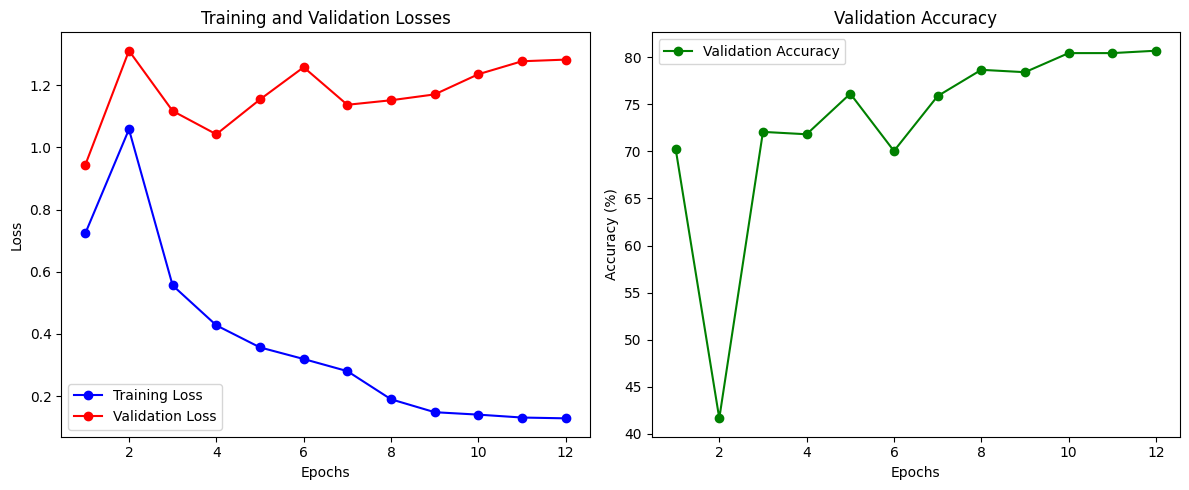

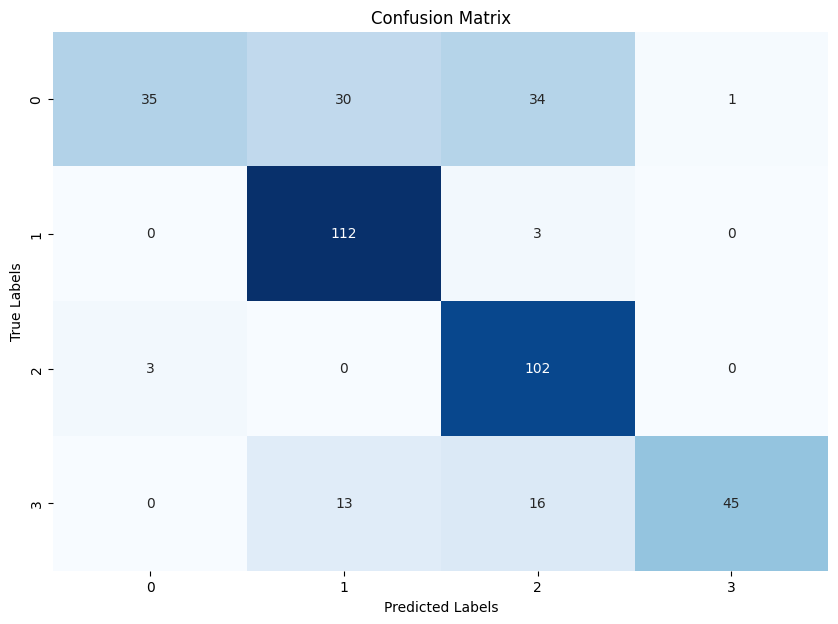

TypeError: cannot unpack non-iterable NoneType object

In [26]:
# Initialize and train each model without CutMix
models_to_train = {
    'ResNet50': get_model('resnet50'),
    'EfficientNetB0': get_model('efficientnet_b0'),
    'DenseNet121': get_model('densenet121')
}

criterion = nn.CrossEntropyLoss()
for name, model in models_to_train.items():
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    print(f'Training {name} without CutMix')
    train_losses, val_losses, accuracies = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)
    val_loss, val_accuracy, conf_matrix = evaluate_model(model, val_loader, criterion)  # Adjust this line as well
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

In [ ]:
import numpy as np
import torch

def cutmix(data, targets, alpha=1.0):
    # Use a try-except block to catch and log potential errors
    try:
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1  # If alpha is 0 or less, do not perform mixing.

        batch_size = data.size(0)
        index = torch.randperm(batch_size).to(data.device)

        # Randomly choose the ratio of the mix
        cut_rat = np.sqrt(1. - lam)
        cut_w = np.round(data.size(2) * cut_rat).astype(int)
        cut_h = np.round(data.size(3) * cut_rat).astype(int)

        # Randomly choose the center of the patch
        cx = np.random.randint(data.size(2))
        cy = np.random.randint(data.size(3))

        bbx1 = np.clip(cx - cut_w // 2, 0, data.size(2))
        bby1 = np.clip(cy - cut_h // 2, 0, data.size(3))
        bbx2 = np.clip(cx + cut_w // 2, 0, data.size(2))
        bby2 = np.clip(cy + cut_h // 2, 0, data.size(3))

        data[:, :, bbx1:bbx2, bby1:bby2] = data[index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / float(data.size(2) * data.size(3)))

        targets_a, targets_b = targets, targets[index]
        return data, targets_a, targets_b, lam
    except Exception as e:
        print(f"Error in cutmix: {str(e)}")
        # Return unmodified data and targets if CutMix fails
        return data, targets, targets, 1.0  # No mixing happened, lam=1

In [ ]:
import torch.optim as optim

def train_with_cutmix(models, train_loader, val_loader, num_epochs=12):
    criterion = nn.CrossEntropyLoss()
    results = {}

    for name, model in models.items():
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        print(f'Training {name} with CutMix')
        trained_model = train_model_with_cutmix(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs)
        print(f'Evaluating {name}')
        accuracy = evaluate_model(trained_model, val_loader)
        results[name] = accuracy

    return results

In [ ]:
def train_model_with_cutmix(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=12, alpha=1.0):
    train_losses = []
    val_losses = []
    accuracies = []
    final_conf_matrix = None  # Initialize to hold the final confusion matrix

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        scheduler.step()

        # Calculate average loss for this epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Evaluate on validation set
        val_loss, val_accuracy, conf_matrix = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        accuracies.append(val_accuracy)
        final_conf_matrix = conf_matrix  # Update the confusion matrix

        print(f'Epoch {epoch + 1}/{num_epochs} - Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
    # Plot metrics after training is complete
    plot_metrics(train_losses, val_losses, accuracies)

    plot_confusion_matrix(conf_matrix, title='Confusion Matrix')
    return train_losses, val_losses, accuracies, final_conf_matrix

Training ResNet50 with CutMix
Epoch 1/12 - Training Loss: 1.0504, Validation Loss: 1.0644, Accuracy: 61.17%
Epoch 2/12 - Training Loss: 0.8732, Validation Loss: 0.8381, Accuracy: 71.57%
Epoch 3/12 - Training Loss: 0.8170, Validation Loss: 0.7480, Accuracy: 76.65%
Epoch 4/12 - Training Loss: 0.7892, Validation Loss: 0.6700, Accuracy: 80.96%
Epoch 5/12 - Training Loss: 0.7429, Validation Loss: 0.7398, Accuracy: 79.95%
Epoch 6/12 - Training Loss: 0.7053, Validation Loss: 0.6199, Accuracy: 82.23%
Epoch 7/12 - Training Loss: 0.6871, Validation Loss: 0.7637, Accuracy: 78.93%
Epoch 8/12 - Training Loss: 0.6503, Validation Loss: 0.6705, Accuracy: 81.73%
Epoch 9/12 - Training Loss: 0.6512, Validation Loss: 0.6897, Accuracy: 80.71%
Epoch 10/12 - Training Loss: 0.6388, Validation Loss: 0.7307, Accuracy: 77.92%
Epoch 11/12 - Training Loss: 0.6462, Validation Loss: 0.6645, Accuracy: 79.95%
Epoch 12/12 - Training Loss: 0.5874, Validation Loss: 0.6908, Accuracy: 79.70%


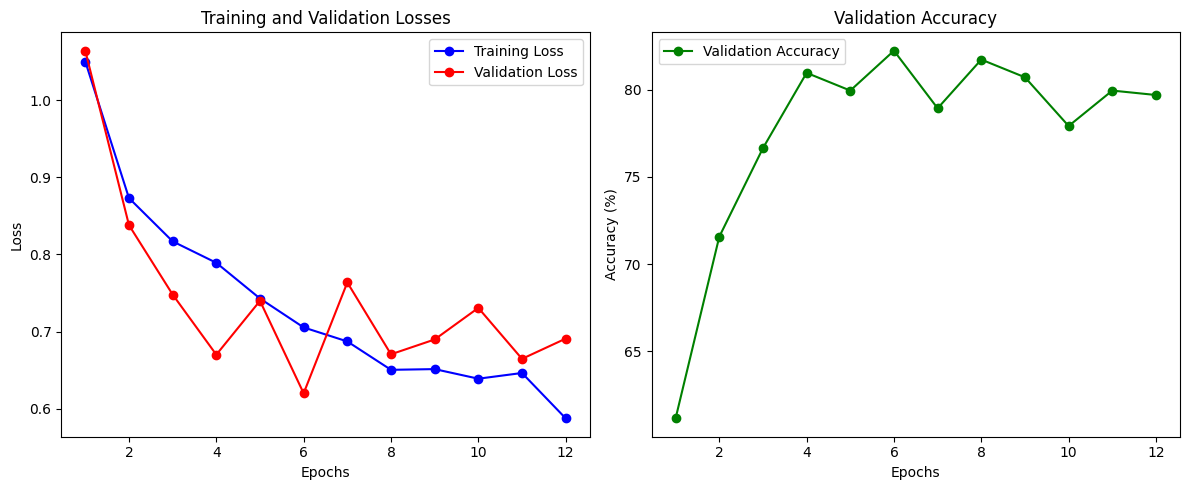

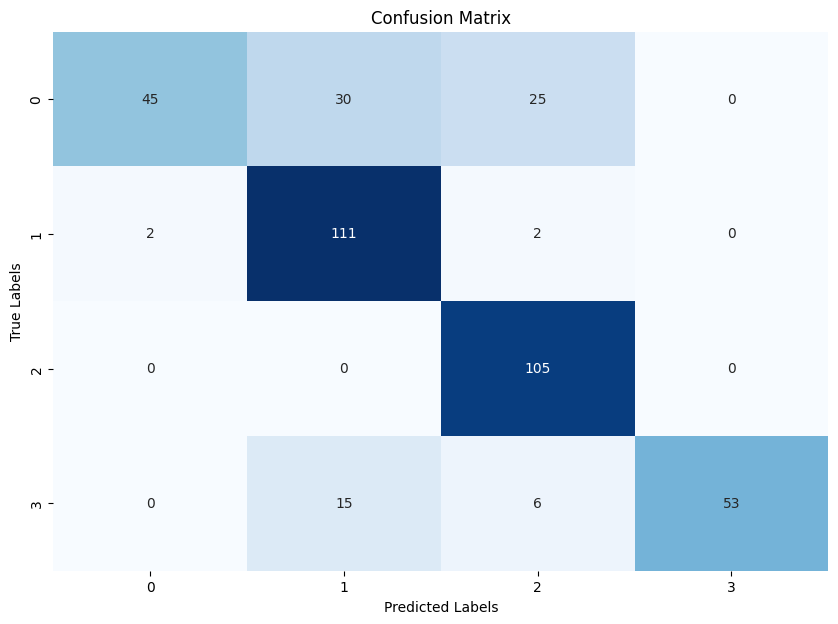

Final Validation Loss: 0.6908, Final Accuracy: 79.70%
Confusion Matrix:
[[ 45  30  25   0]
 [  2 111   2   0]
 [  0   0 105   0]
 [  0  15   6  53]]
Training EfficientNetB0 with CutMix
Epoch 1/12 - Training Loss: 1.0594, Validation Loss: 1.0963, Accuracy: 53.30%
Epoch 2/12 - Training Loss: 0.9229, Validation Loss: 1.0877, Accuracy: 58.63%
Epoch 3/12 - Training Loss: 0.8630, Validation Loss: 0.8128, Accuracy: 72.84%
Epoch 4/12 - Training Loss: 0.8228, Validation Loss: 0.7140, Accuracy: 77.16%
Epoch 5/12 - Training Loss: 0.8233, Validation Loss: 0.7260, Accuracy: 75.89%
Epoch 6/12 - Training Loss: 0.8034, Validation Loss: 0.7807, Accuracy: 76.90%
Epoch 7/12 - Training Loss: 0.7941, Validation Loss: 0.7652, Accuracy: 78.43%
Epoch 8/12 - Training Loss: 0.7601, Validation Loss: 0.7695, Accuracy: 77.16%
Epoch 9/12 - Training Loss: 0.7703, Validation Loss: 0.6907, Accuracy: 79.44%
Epoch 10/12 - Training Loss: 0.7264, Validation Loss: 0.7048, Accuracy: 79.44%
Epoch 11/12 - Training Loss: 0.725

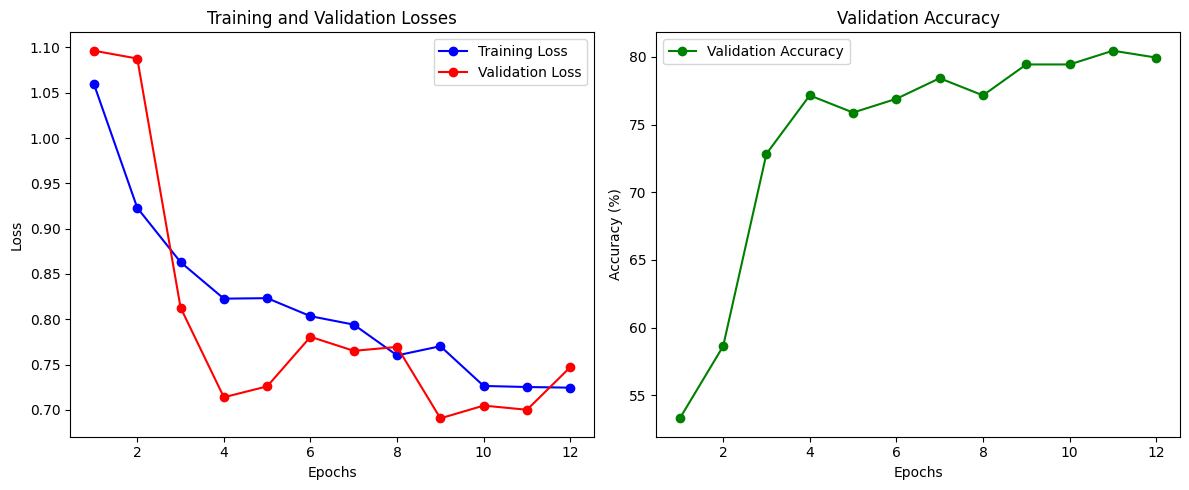

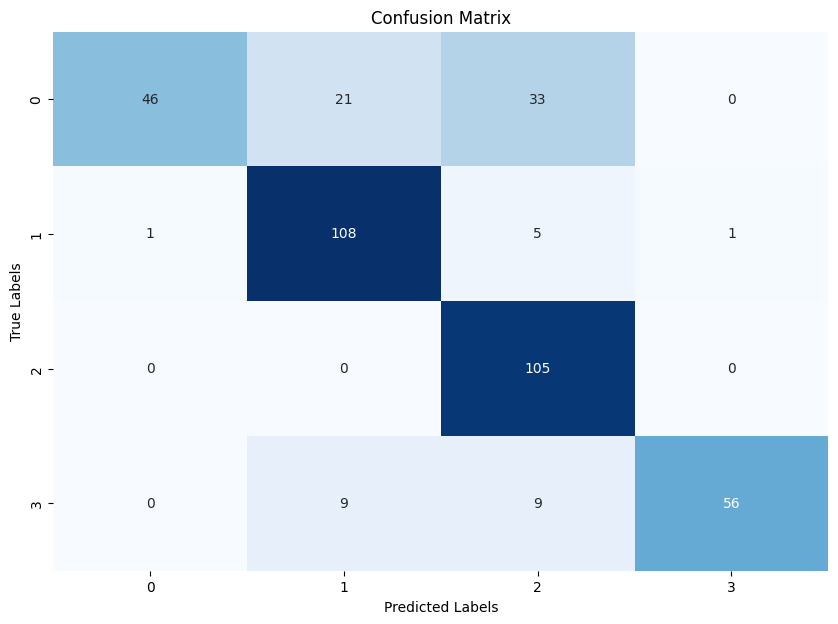

Final Validation Loss: 0.7472, Final Accuracy: 79.95%
Confusion Matrix:
[[ 46  21  33   0]
 [  1 108   5   1]
 [  0   0 105   0]
 [  0   9   9  56]]
Training DenseNet121 with CutMix
Epoch 1/12 - Training Loss: 1.0241, Validation Loss: 1.2635, Accuracy: 57.87%
Epoch 2/12 - Training Loss: 0.8928, Validation Loss: 0.8773, Accuracy: 71.07%
Epoch 3/12 - Training Loss: 0.9033, Validation Loss: 0.9332, Accuracy: 69.29%
Epoch 4/12 - Training Loss: 0.8232, Validation Loss: 0.7254, Accuracy: 75.63%
Epoch 5/12 - Training Loss: 0.8254, Validation Loss: 0.7337, Accuracy: 75.13%
Epoch 6/12 - Training Loss: 0.8338, Validation Loss: 0.7994, Accuracy: 69.80%
Epoch 7/12 - Training Loss: 0.8038, Validation Loss: 0.7711, Accuracy: 69.04%
Epoch 8/12 - Training Loss: 0.7808, Validation Loss: 0.7147, Accuracy: 73.60%
Epoch 9/12 - Training Loss: 0.7484, Validation Loss: 0.6682, Accuracy: 76.90%
Epoch 10/12 - Training Loss: 0.7409, Validation Loss: 0.6223, Accuracy: 79.70%
Epoch 11/12 - Training Loss: 0.7681, 

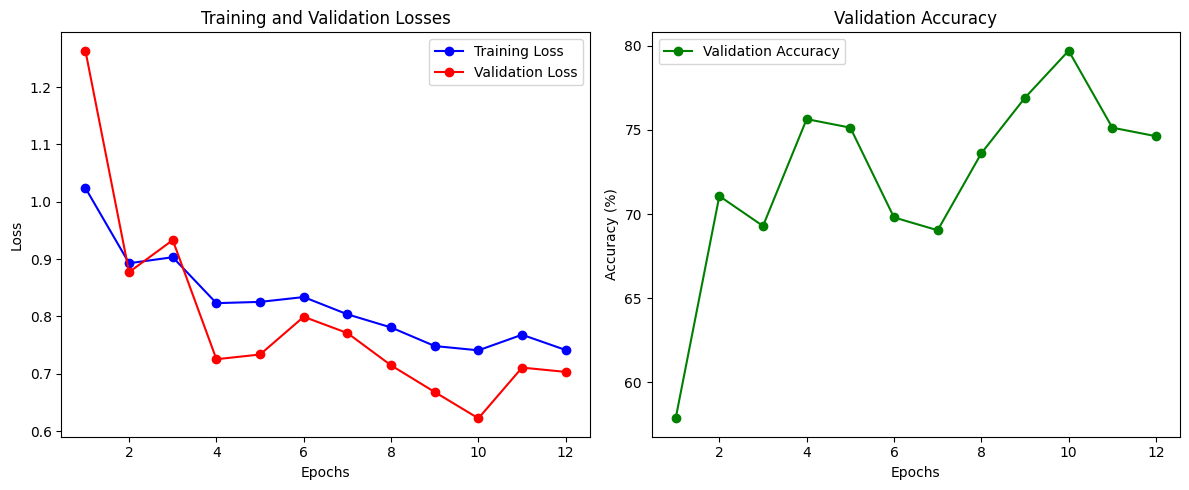

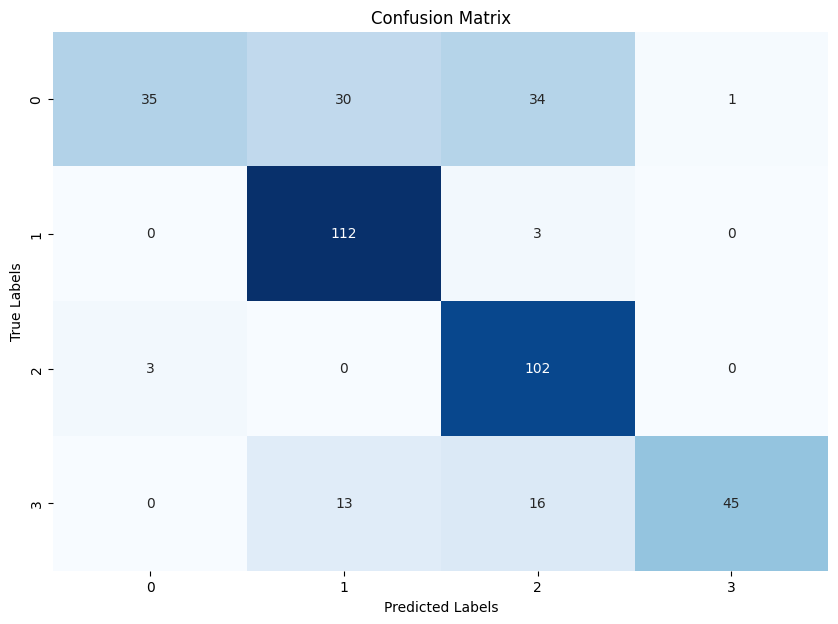

Final Validation Loss: 0.7033, Final Accuracy: 74.62%
Confusion Matrix:
[[ 35  30  34   1]
 [  0 112   3   0]
 [  3   0 102   0]
 [  0  13  16  45]]


In [21]:
models_to_train = {
    'ResNet50': get_model('resnet50'),
    'EfficientNetB0': get_model('efficientnet_b0'),
    'DenseNet121': get_model('densenet121')
}

criterion = nn.CrossEntropyLoss()
for name, model in models_to_train.items():
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    print(f'Training {name} with CutMix')

    # Perform training with CutMix and handle all the returns
    train_losses, val_losses, accuracies, conf_matrix = train_model_with_cutmix(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=12, alpha=1.0)
    print(f'Final Validation Loss: {val_losses[-1]:.4f}, Final Accuracy: {accuracies[-1]:.2f}%')
    print(f'Confusion Matrix:\n{conf_matrix}')

In [ ]:
# Plot metrics after training is complete
plot_metrics(train_losses, val_losses, accuracies)

plot_confusion_matrix(conf_matrix, title='Confusion Matrix')

In [ ]:
from torch.utils.data import DataLoader

# Assuming the DataLoader is set up like this
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Number of files might be calculated as
print(f"Total training samples used: {len(train_loader.dataset)}")

In [ ]:
alpha_values = [0.1, 0.4, 1.0, 2.0]  # Range of alpha values for CutMix
learning_rates = [0.001, 0.0001, 0.00001]  # Different learning rates
batch_sizes = [8, 16, 32]  # Different batch sizes to test

In [ ]:
from itertools import product

best_accuracy = 0
best_params = {}

# Loop through all combinations of hyperparameters
for alpha, lr, batch_size in product(alpha_values, learning_rates, batch_sizes):
    print(f"Testing alpha={alpha}, lr={lr}, batch_size={batch_size}")

    # Set up data loaders with current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize and train the model with current alpha and lr
    for name, model in models_to_train.items():
        model = get_model(name)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        trained_model, accuracy, conf_matrix = train_model_with_cutmix(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=12, alpha=alpha)

        # Plot and store results if better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'alpha': alpha, 'lr': lr, 'batch_size': batch_size, 'model': name}
            plot_confusion_matrix(conf_matrix, title=f'Best Confusion Matrix for {name} with alpha={alpha}, lr={lr}, batch_size={batch_size}')

print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy}")